In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import time

In [3]:
df = pd.read_csv('iris.csv')

In [4]:
df.head(5)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [56]:
X = df.loc[:, ['sepal.length', 'sepal.width', 'petal.length', 'petal.width']].values.tolist()
y = pd.get_dummies(df.loc[:, 'variety']).values.tolist()      # one hot encoding

# mean of each feature
means = []
for col in range(len(X[0])):
    temp = 0
    for row in range(len(X)):
        temp += X[row][col]
    temp /= len(X)
    means.append(temp)

# std of each feature
stds = []
for col in range(len(X[0])):
    sum_mean_square = 0
    for row in range(len(X)):
        sum_mean_square += (X[row][col] - means[col]) ** 2
    sum_mean_square /= len(X)
    stds.append(math.sqrt(sum_mean_square))

# Normalize data
for row in range(len(X)):
    for col in range(len(X[0])):
        X[row][col] = (X[row][col] - means[col]) / stds[col]

# Add bias
X = [[1.] + x for x in X]

# Split train and test data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Get n_features & n_classes
n_features = len(X[0])
n_classes = len(y[0])
print(f"features: {n_features}, classes: {n_classes}")

features: 5, classes: 3


In [57]:
def softmax(z):
    exp_z = [math.exp(i) for i in z]
    sum_exp_z = sum(exp_z)
    return [i / sum_exp_z for i in exp_z]

def loss_entropy(y_hat, y):
    row = len(y); col = len(y[0])
    loss = sum([sum([-y[i][j] * math.log(y_hat[i][j] + 1e-9) for j in range(col)]) for i in range(row)]) / row
    return loss

# def dot(x, y):
#     result = [[0 for _ in range(len(y[0]))] for _ in range(len(x))]
#     for row in range(len(x)):
#         for col in range(len(y[0])):
#             for k in range(len(y)):
#                 result[row][col] += x[row][k] * y[k][col]
#     return result

def dot(X, Y):
    return [[sum(a * b for a, b in zip(row, col)) for col in zip(*Y)] for row in X]

def scalar_mul(scalar, X, one_dim = False):
    if one_dim:
        return [scalar * x for x in X]
    return [[scalar * t for t in x] for x in X]

def add(x, y, one_dim = False):
    if one_dim:
        return [x[i] + y[i] for i in range(len(x))]
    return [[x[row][col] + y[row][col] for col in range(len(x[0]))] for row in range(len(x))]

def sub(x, y, one_dim = False):
    if one_dim:
        return [x[i] - y[i] for i in range(len(x))]
    return [[x[row][col] - y[row][col] for col in range(len(x[0]))] for row in range(len(x))]

def transpose(x):
    return [[x[row][col] for row in range(len(x))] for col in range(len(x[0]))]

def argmax(x):
    index = 0
    max_val = x[0]
    for idx, value in enumerate(x):
        if value >= max_val:
            max_val = value
            index = idx
    return index

In [87]:
class SoftmaxRegression:
    def __init__(self, n_features, n_classes, lr=0.1, epoch_max=1001):
        self.n_features = n_features
        self.n_classes = n_classes
        self.lr = lr
        self.epoch_max = epoch_max
        self.losses = []

    def fit(self, X, y):
        self.w = [[0. ] * self.n_classes for _ in range(self.n_features)]
        self.b = [0.] * self.n_classes

        for epoch in range(self.epoch_max):
            # calculate
            zs = dot(X, self.w)
            zs = [[zs[i][j] + self.b[j] for j in range(len(zs[0]))] for i in range(len(zs))]
            y_hat = [softmax(z) for z in zs]

            # calculate loss
            loss = loss_entropy(y_hat, y)
            self.losses.append(loss)

            # gradient
            gradient_z = sub(y_hat, y)
            grad_w = dot(transpose(X), gradient_z)
            grad_b = [sum(grad_z) for grad_z in gradient_z]

            # update weights and bias
            self.w = sub(self.w, scalar_mul(self.lr, grad_w))
            self.b = sub(self.b, scalar_mul(self.lr, grad_b, True), one_dim=True)

            if epoch % 100 == 0:
                print(f"Epoch {epoch}: loss = {loss:.5f}")

    def predict(self, X):
        zs = dot(X, self.w)
        zs = [[zs[i][j] + self.b[j] for j in range(len(zs[0]))] for i in range(len(zs))]
        y_hat = [softmax(z) for z in zs]
        return [argmax(y_hat[row]) for row in range(len(y_hat))]

    def cal_accuracy(self, y_hat, y):
        return sum(y[row] == y_hat[row] for row in range(len(y))) / len(y)

    def test(self, x_test, y_test):
        y_predict = self.predict(x_test)
        y = [argmax(row) for row in y_test]
        accuracy_score = self.cal_accuracy(y_predict, y)
        return accuracy_score

    def plot_loss(self):
        plt.plot(self.losses)
        plt.ylabel("Losses")
        plt.xlabel("Epoch")
        plt.title("Loss")
        plt.show()

Epoch 0: loss = 1.09861
Epoch 100: loss = 0.05222
Epoch 200: loss = 0.04962
Epoch 300: loss = 0.04854
Epoch 400: loss = 0.04796
Epoch 500: loss = 0.04761
Epoch 600: loss = 0.04737
Epoch 700: loss = 0.04721
Epoch 800: loss = 0.04709
Epoch 900: loss = 0.04700
Epoch 1000: loss = 0.04693
=> Accuracy: 0.9833


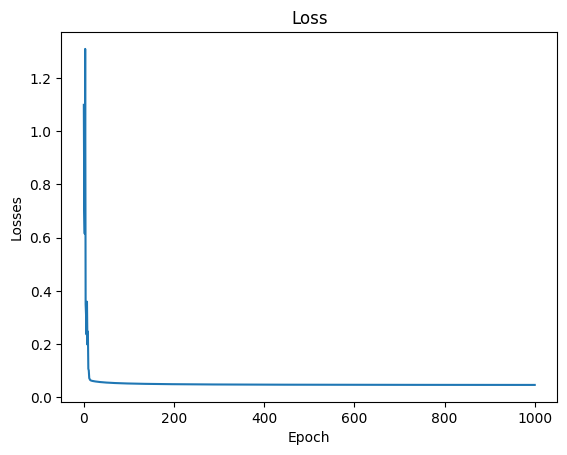

In [90]:
start_train = time.time()
model = SoftmaxRegression(n_features, n_classes, lr=0.1, epoch_max=1001)
model.fit(x_train, y_train)
accuracy = model.test(x_train, y_train)
end_train = time.time()

print(f"=> Accuracy: {accuracy:.4f}")
model.plot_loss()

In [89]:
start_test = time.time()
accuracy = model.test(x_test, y_test)
end_test = time.time()

print(f"=> Accuracy: {accuracy:.4f}")
print(f"- Training time: {end_train - start_train:.3f} (s)")
print(f"- Testing time: {end_test - start_test:.3f} (s)")

=> Accuracy: 1.0000
- Training time: 4.319 (s)
- Testing time: 0.000 (s)
